## PHYS 249 Lab 11: Image Analysis

In [3]:
# common import statements

from matplotlib.pyplot import plot, show, imshow, gray, hist, figure
from numpy import asarray, ravel, sqrt, zeros, exp

# PIL (Python Imaging Library) 
from PIL import Image


### 11.1: Read in image, print its properties and display it

PNG
(480, 480)
RGBA
(480, 480, 4)


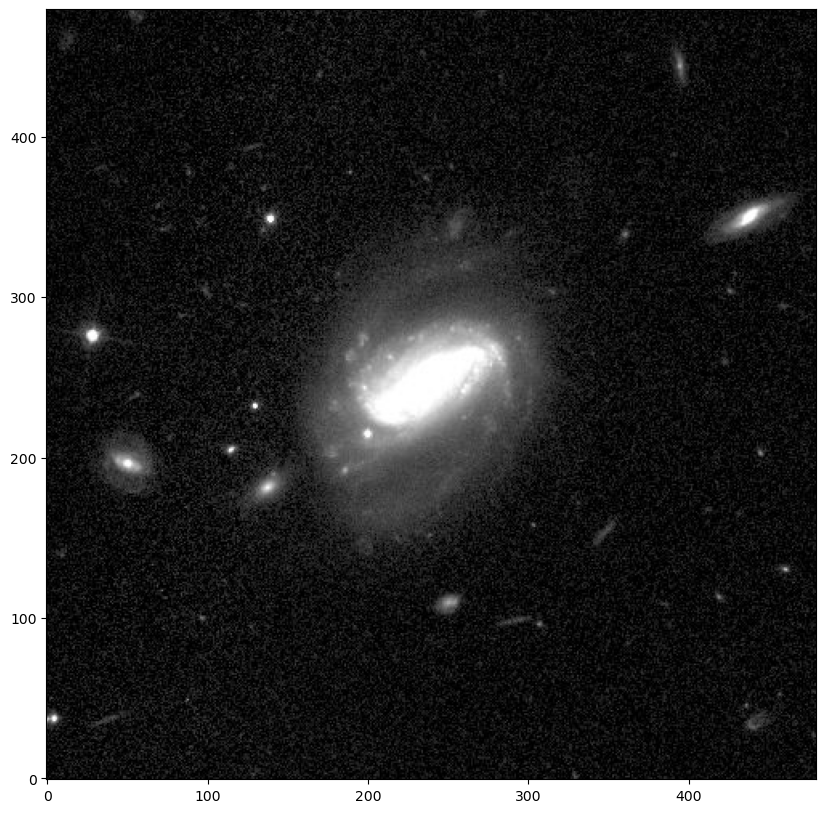

PNG
(480, 480)
RGBA
(480, 480, 4)


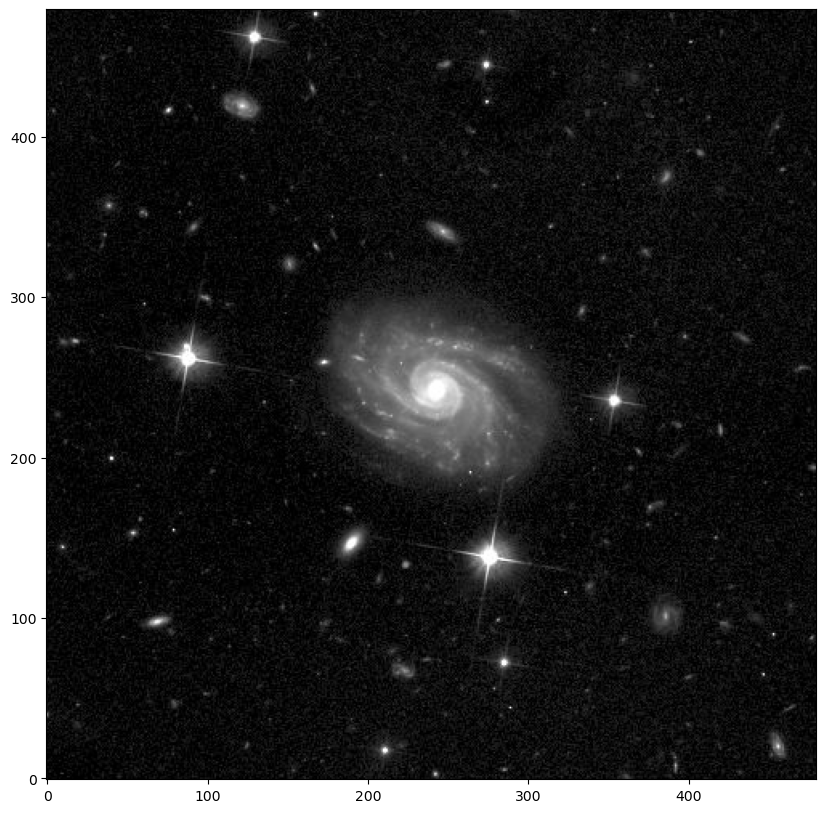

In [5]:
image = Image.open('150d375_2d285_a.png')

# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

# convert image to numpy array
img_array = asarray(image)
print(img_array.shape)

# show the image
figure(figsize = (10,10))
imshow(img_array,origin="lower")
show()



image = Image.open('149d782_2d704_a.png')

# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

# convert image to numpy array
img_array = asarray(image)
print(img_array.shape)

# show the image
figure(figsize = (10,10))
imshow(img_array,origin="lower")
show()

### 11.2: Make a (log) histogram of the pixel values and select range of interest

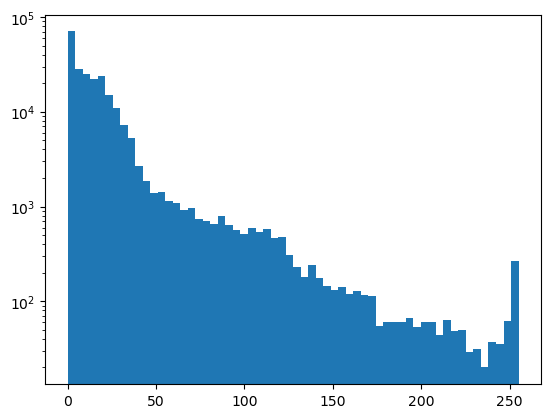

In [6]:
img = img_array[:,:,0]

def im_hist(img):
    px = ravel(img)
    mean = sum(px)/len(px)
    pxc = px - mean
    stddev = sqrt(sum(pxc*pxc)/len(px))
    n, bins, patches = hist(px, 60, histtype='stepfilled',log=True)
#     lx = [mean, mean]
#     ly = [0,max(px)]
#     #plot(lx,ly)
    show()

im_hist(img)


### 11.3: Mask out background

<Figure size 640x480 with 0 Axes>

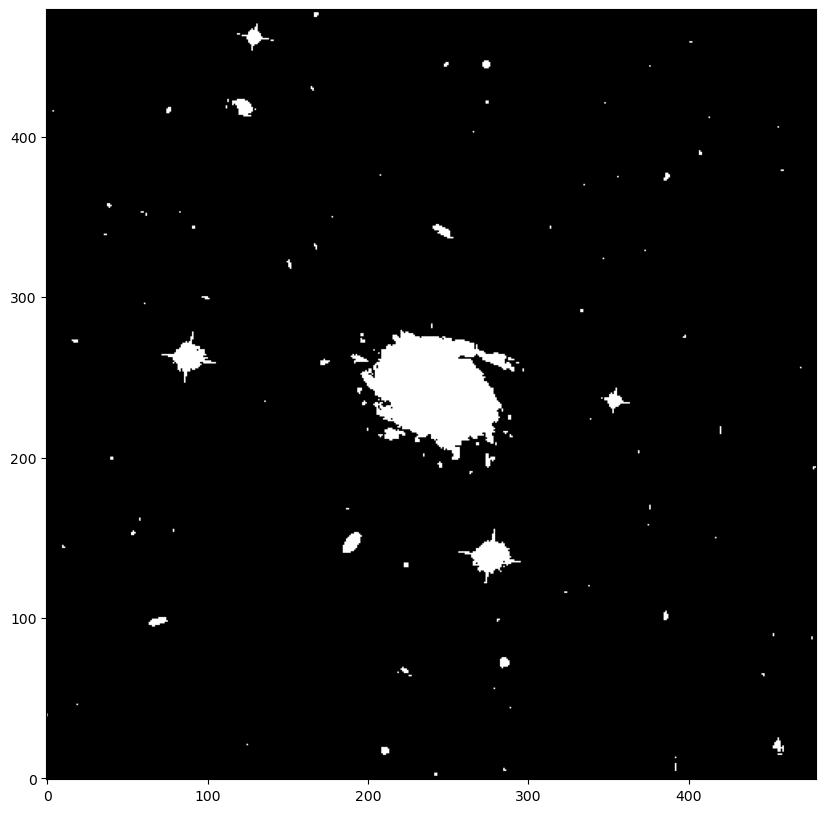

In [7]:
def im_bgseg(img,n): #finds pixel values n away from mean
    side = img.shape[0]
    px = ravel(img)
    mean = sum(px)/len(px)
    pxc = px - mean
    stddev = sqrt(sum(pxc*pxc)/len(px))
    seg = zeros([side,side],float)
    for i in range(side):
        for j in range(side):
            if (abs(img[i,j] - mean) > n*stddev):
                seg[i,j] = 1.0
    return seg                
# result is an array of zeros/ones tracing bakcground/objects

# try this out, making >3 sigma image
seg = im_bgseg(img,3)
gray()
figure(figsize = (10,10))
imshow(seg,origin="lower")


### 11.4: Smooth (note this is slow)

<Figure size 640x480 with 0 Axes>

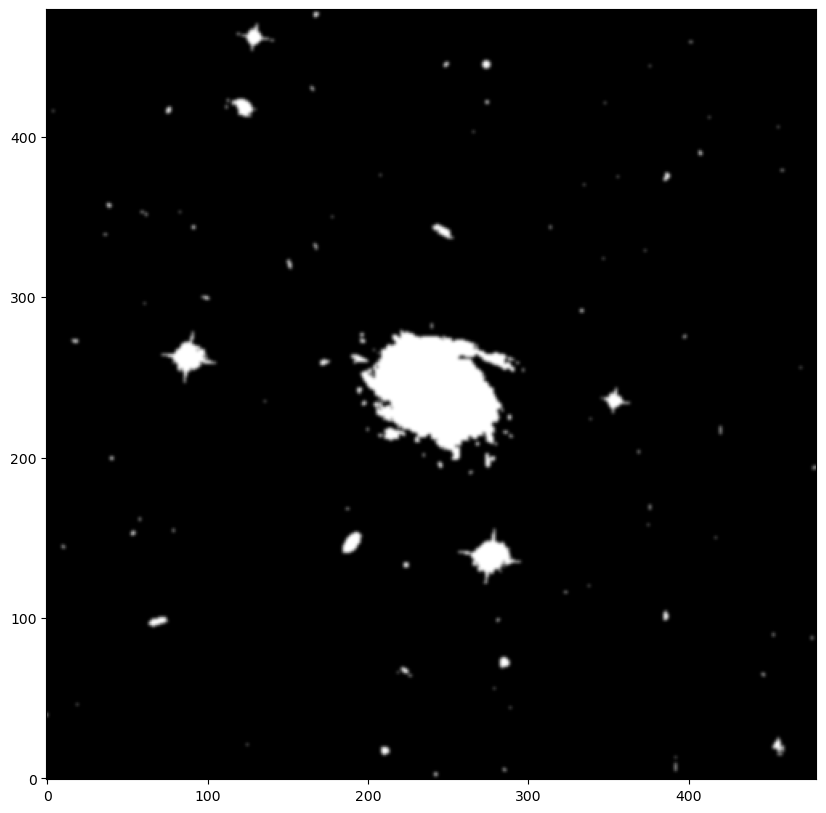

In [8]:
# smooths image with Gaussian filter
def gaussf_img(img,di):

    side = img.shape[0] #assumed square for the moment

    # filter shape - doesn't have to be normalized    
    wd = 2*di + 1
    w = zeros([wd,wd], float)

    for i in range(0,wd,1):
        for j in range(0,wd,1):
            x = 2.0*float(i - di)/float(di)
            y = 2.0*float(j - di)/float(di)
            w[i,j] = exp(-(x*x+y*y)/2.0)

    N = side
    simg = zeros([N,N],float)
    if 1:
        for i in range(0, N, 1):       # for every x
            for m in range(0, N, 1):   # for every y
                wt = 0.0
                for j in range(-di, di+1, 1):       # convolve along x axis
                    for n in range(-di, di+1, 1):   # convolve along y axis
                        if ((i+j) >= 0) and ((i+j) < N) and ((m+n) >= 0) and ((m+n) < N):
                            simg[i,m] += w[j+di,n+di]*img[i+j,m+n]
                            wt += w[j+di,n+di]
                simg[i,m] = simg[i,m]/wt
    return simg

#now filter in 2-D
sseg = gaussf_img(seg,2)
gray()
figure(figsize = (10,10))
imshow(sseg,origin="lower")

### 11.5: Find Edges (in Smoothed Image)

<Figure size 640x480 with 0 Axes>

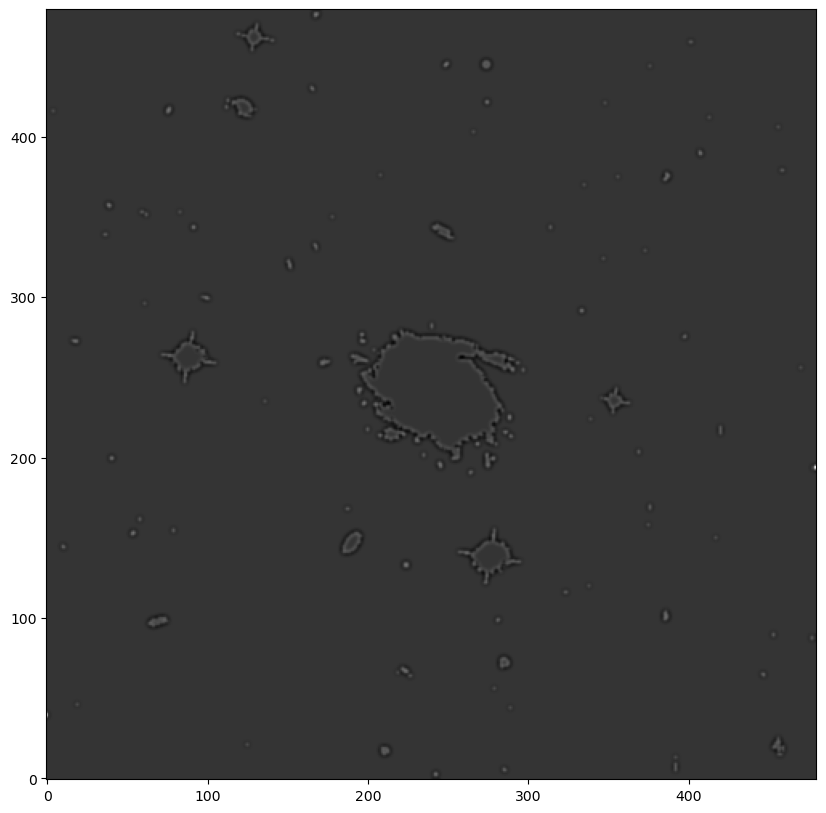

In [9]:
# filters image to detect edge
def edgef_img(img): #assumes a 3x3 filter size

    di = 1
    side = img.shape[0] #assumed square for the moment

    # filter shape - doesn't have to be normalized    
    wd = 2*di + 1
    w = zeros([wd,wd], float)

    for i in range(0,wd,1):
        for j in range(0,wd,1):
            w[i,j] = -1.0/8.0
    w[1,1] = 1.0

    N = side
    simg = zeros([N,N],float)
    if 1:
        for i in range(0, N, 1):       # for every x
            for m in range(0, N, 1):   # for every y
                wt = 0.0
                for j in range(-di, di+1, 1):       # convolve along x axis
                    for n in range(-di, di+1, 1):   # convolve along y axis
                        if ((i+j) >= 0) and ((i+j) < N) and ((m+n) >= 0) and ((m+n) < N):
                            simg[i,m] += w[j+di,n+di]*img[i+j,m+n]
                            wt += w[j+di,n+di]
                if abs(wt) > 1e-5: 
                    simg[i,m] = simg[i,m]/wt
    return simg


#now find edge
edg = edgef_img(sseg)
gray()
figure(figsize = (10,10))
imshow(edg,origin="lower")


### 11.6: Highlight Boundaries

<Figure size 640x480 with 0 Axes>

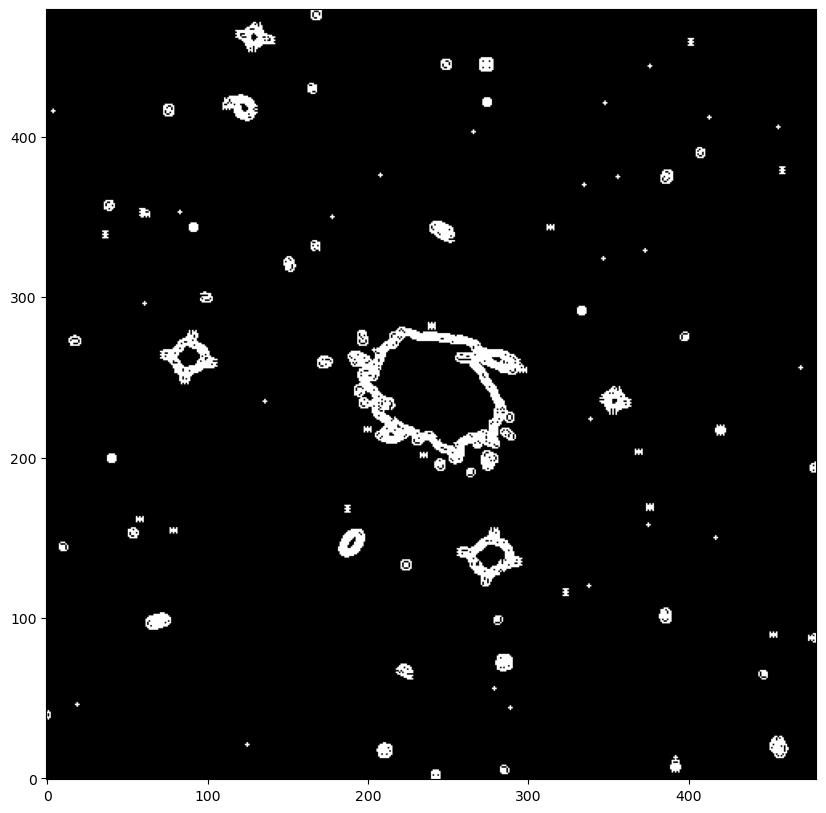

In [10]:
# set background to zero to highlight boundary
seg2 = im_bgseg(edg,1.5)

#show resulting boundary
gray()
figure(figsize = (10,10))
imshow(seg2,origin="lower")


### 11.7 Set background/image region to zero in original image

<Figure size 640x480 with 0 Axes>

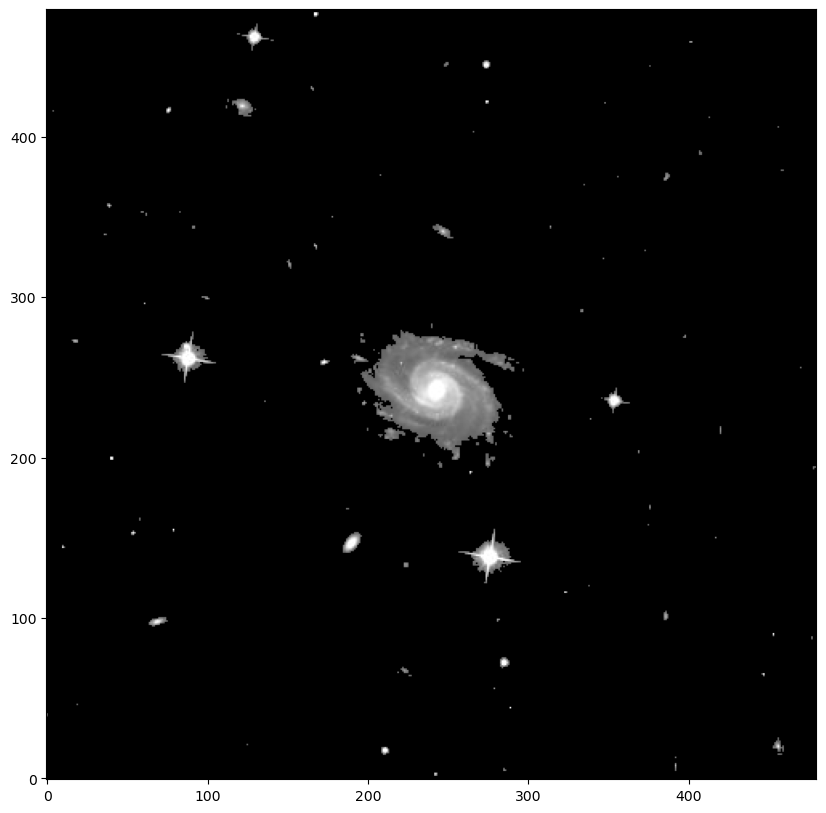

In [11]:
def im_mask(img,msk,n): #saves pixels w. value close to n

    side = img.shape[0]
    outp = zeros([side,side],float)
    for i in range(side):
        for j in range(side):
            if(abs(msk[i,j]- n) < 1e-5):
                outp[i,j] = img[i,j]
    return outp                

def im_antimask(img,msk,n): #saves pixels w. value close to n

    side = img.shape[0]
    outp = zeros([side,side],float)
    for i in range(side):
        for j in range(side):
            if(abs(msk[i,j]- n) > 1e-5):
                outp[i,j] = img[i,j]
    return outp                

# mask out background
cutimg = im_mask(img, seg, 1.0)
gray()
figure(figsize = (10,10))
imshow(cutimg,origin="lower")

# could also mask out object
#cutimg = im_antimask(img, seg, 1.0)
#figure(figsize = (10,10))
#imshow(cutimg,origin="lower")

### Questions:

**a)** Why is the smoothing step slow? Can you estimate how long it should take?

**b)** Write code based on *im_bgseg* that sets all pixels below a fixed value, say 5.0, to zero. Adjust the value of the cut to select the pixels of the central galaxy as well as you can.

**c)** Write code that makes a mask for a circular region at the centre of the image, setting everything outside some radius to zero, and everything inside to 1.

**d)** Combining the code from **c** with im_seg, write code to measure the area (in pixels) of the central galaxy.

**e)** Try all the steps of the notebook out with the image 149d782_2d704_a.png.

**f)** (Advanced!) In an image with multiple distinct objects above the background, can you think of a way of distinguishing one object from another?


<Figure size 640x480 with 0 Axes>

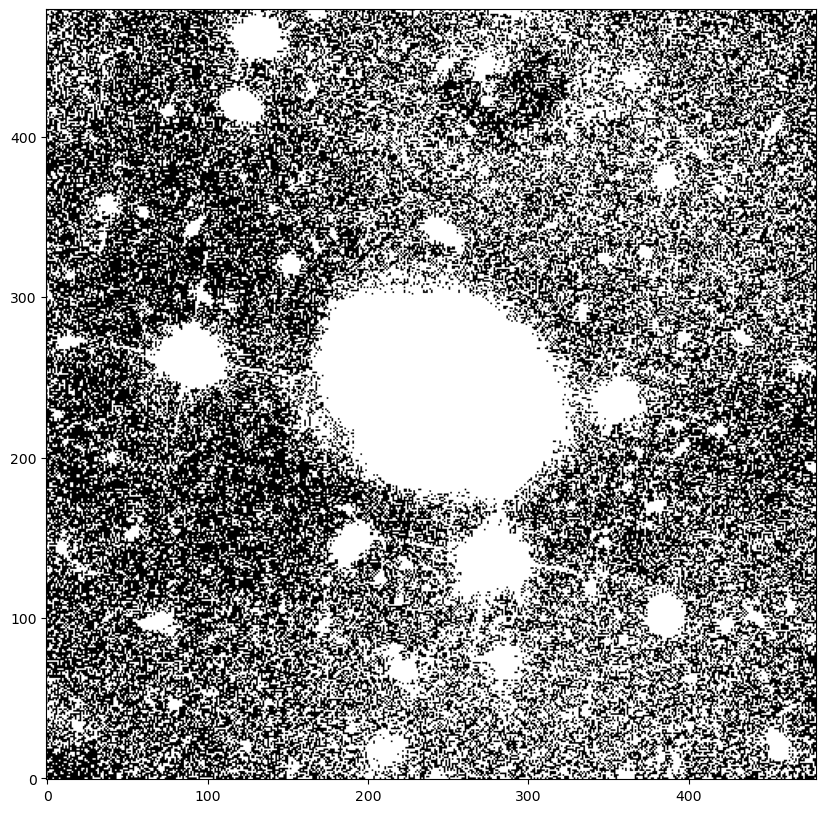

In [12]:
# a) Smoothing step is slow as it has 4 for loops. Using big O notation we can roughly
# estimate the time it takes for the code to run

# b)
def im_seg(img,n): 
    side = img.shape[0]
    seg = zeros([side,side],float)
    for i in range(side):
        for j in range(side):
            if (abs(img[i,j]) > n):
                seg[i,j] = 1.0
    return seg                

seg = im_seg(img,10)
gray()
figure(figsize = (10,10))
imshow(seg,origin="lower")



15393.804002589986


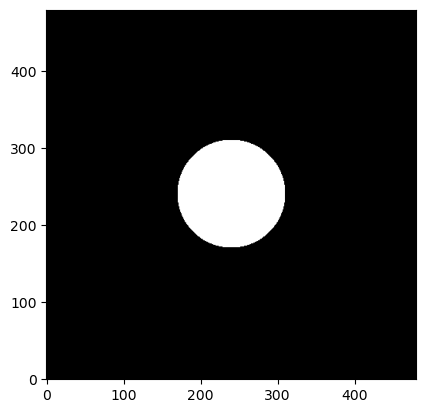

In [21]:
# c)
import numpy as np
def circlemask(center_x, center_y, radius, side):
    mask = zeros([side, side])
    for i in range(side):
        for j in range(side):
            if((i-center_x)**2 + (j-center_y)**2 < radius**2):
                mask[i][j] = 1
    return mask
cmak = circlemask(240, 240, 70, 480)
imshow(cmak, origin = "lower")

# d) finding the area of the cirlce
print(np.pi*70**2)

# e)

# f) Intensity of the image or use relative brightness. We could also use the fact that light bends around a
# a star and use that to find the imaging of a far object.